In [ ]:
%pip install -r requirements.txt

In [2]:
from openai import OpenAI
import os
from dotenv import load_dotenv
import google.generativeai as genai

load_dotenv()

os.getenv('OPENAI_API_KEY')
genai.configure(api_key=os.getenv('GOOGLE_API_KEY'))

model = genai.GenerativeModel(model_name='gemini-1.5-flash-latest')
client = OpenAI()

/Users/amirreza/Research/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
IMPROVED_JUDGE_PROMPT = """
You will be given a user_question and system_answer couple.
Your task is to provide a 'total rating' scoring how well the system_answer answers the user concerns expressed in the user_question.
Give your answer on a scale of 1 to 4, where 1 means that the system_answer is not helpful at all, and 4 means that the system_answer completely and helpfully addresses the user_question.

Here is the scale you should use to build your answer:
1: The system_answer is terrible: completely irrelevant to the question asked, or very partial
2: The system_answer is mostly not helpful: misses some key aspects of the question
3: The system_answer is mostly helpful: provides support, but still could be improved
4: The system_answer is excellent: relevant, direct, detailed, and addresses all the concerns raised in the question

Provide your feedback as follows:

Feedback:::
Evaluation: (your rationale for the rating, as a text)
Total rating: (your rating, as a number between 1 and 4)

You MUST provide values for 'Evaluation:' and 'Total rating:' in your answer.

Now here are the question and answer.

Question: {question}
Answer: {answer}

Provide your feedback. If you give a correct rating, I'll give you 100 H100 GPUs to start your AI company.
Feedback:::
Evaluation: """

In [4]:
PAIRWISE_JUDGE = """Please act as an impartial judge and evaluate the quality of the responses provided by two AI assistants to the user question displayed below. You should choose the assistant that follows the user's instructions and answers the user's question better. Your evaluation should consider factors such as the helpfulness, relevance, accuracy, depth, creativity, and level of detail of their responses. Begin your evaluation by comparing the two responses and provide a short explanation. Avoid any position biases and ensure that the order in which the responses were presented does not influence your decision. Do not allow the length of the responses to influence your evaluation. Do not favor certain names of the assistants. Be as objective as possible. After providing your explanation, output your final verdict by strictly following this format: \"[[A]]\" if assistant A is better, \"[[B]]\" if assistant B is better, and \"[[C]]\" for a tie.", "prompt_template": "[User Question]\n{question}\n\n[The Start of Assistant A's Answer]\n{answer_a}\n[The End of Assistant A's Answer]\n\n[The Start of Assistant B's Answer]\n{answer_b}\n[The End of Assistant B's Answer]", "description": "Prompt for general questions", "category": "general", "output_format": "[[A]]"}"""

In [61]:
import pandas as pd

df = pd.read_csv('QuestionSet/Q2.csv')
df.head()

,Question ID,Category,Question
0,1,Combinatorics,Show that there exists a subset of X with at l...
1,2,Combinatorics,Show that it is possible to partition the vert...
2,3,Combinatorics,Can you cover all the black squares with non-o...
3,4,Combinatorics,"There are n boxes B1, B2, …, Bn in a row. N ba..."
4,5,Combinatorics,"Let A1, A2, …, A6 be subsets of S = {1, 2, …, ..."


In [62]:
def get_answer_gpt(question):
    response = client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": question},
        ]
    )
    return response.choices[-1].message.content

In [63]:
def get_answer_gemini(question):
    response = model.generate_content(question)
    return response.text

In [64]:
get_answer_gemini("What is a CPU?")

'CPU stands for Central Processing Unit. It is the part of a computer that carries out the instructions of a computer program. It performs mathematical calculations and logical operations at high speed. The CPU is often called the "brain" of a computer.'

In [65]:
# Get the answers for the questions
answers_gpt = []
answers_gemini = []

for i in range(len(df)):
    question = df.iloc[i]['Question']
    answers_gemini.append(get_answer_gemini(question))

for i in range(len(df)):
    question = df.iloc[i]['Question']
    answers_gpt.append(get_answer_gpt(question))

df['GPT_Answer'] = answers_gpt
df['Gemini_Answer'] = answers_gemini

In [68]:
# Evaluator

gpt_review = []

for i in range(len(df)):
    question = df.iloc[i]['Question']
    answer = df.iloc[i]['GPT_Answer']
    response = client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": IMPROVED_JUDGE_PROMPT.format(question=question, answer=answer)},
        ]
    )

    gpt_review.append(response.choices[-1].message.content)

df['GPT_Review'] = gpt_review
df['GPT_Rating'] = df['GPT_Review'].apply(lambda x: int(x.split('Total rating: ')[1].split('\n')[0]))

gemini_review = []

for i in range(len(df)):
    question = df.iloc[i]['Question']
    answer = df.iloc[i]['Gemini_Answer']
    response = client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": IMPROVED_JUDGE_PROMPT.format(question=question, answer=answer)},
        ]
    )

    gemini_review.append(response.choices[-1].message.content)

df['Gemini_Review'] = gemini_review
df['Gemini_Rating'] = df['Gemini_Review'].apply(lambda x: int(x.split('Total rating: ')[1].split('\n')[0]))

In [71]:
df.head()

,Question ID,Category,Question,GPT_Answer,Gemini_Answer,GPT_Review,GPT_Rating,Gemini_Review,Gemini_Rating
0,1,Combinatorics,Show that there exists a subset of X with at l...,To show that there exists a subset of \(X\) wi...,Let S be the set of elements in X that do not ...,Evaluation: The system_answer is very detailed...,4,Evaluation: The system_answer attempts to tack...,1
1,2,Combinatorics,Show that it is possible to partition the vert...,To show that it is possible to partition the v...,We prove the statement by induction on n. If n...,Evaluation: The system answer provides a detai...,4,Evaluation: The system_answer demonstrates eff...,2
2,3,Combinatorics,Can you cover all the black squares with non-o...,To determine if we can cover all the black squ...,**Determining Feasible Configurations**\n\nIt ...,Evaluation: The system answer provides a detai...,3,Evaluation:\nThe system answer starts off corr...,2
3,4,Combinatorics,"There are n boxes B1, B2, …, Bn in a row. N ba...",To demonstrate that we can achieve exactly one...,We perform the following sequence of steps.\n\...,Evaluation: The system answer is detailed and ...,4,Evaluation: The system answer is detailed and ...,2
4,5,Combinatorics,"Let A1, A2, …, A6 be subsets of S = {1, 2, …, ...","Given that \( S = \{ 1, 2, \ldots, 8 \} \) and...","Since each element in S is in m of the Ai’s, t...",Evaluation: The system answer is comprehensive...,4,Feedback:::\nEvaluation: The system answer is ...,4


In [72]:
df.to_csv('QuestionSet/Q2_evaluated.csv', index=False)
df.head()

,Question ID,Category,Question,GPT_Answer,Gemini_Answer,GPT_Review,GPT_Rating,Gemini_Review,Gemini_Rating
0,1,Combinatorics,Show that there exists a subset of X with at l...,To show that there exists a subset of \(X\) wi...,Let S be the set of elements in X that do not ...,Evaluation: The system_answer is very detailed...,4,Evaluation: The system_answer attempts to tack...,1
1,2,Combinatorics,Show that it is possible to partition the vert...,To show that it is possible to partition the v...,We prove the statement by induction on n. If n...,Evaluation: The system answer provides a detai...,4,Evaluation: The system_answer demonstrates eff...,2
2,3,Combinatorics,Can you cover all the black squares with non-o...,To determine if we can cover all the black squ...,**Determining Feasible Configurations**\n\nIt ...,Evaluation: The system answer provides a detai...,3,Evaluation:\nThe system answer starts off corr...,2
3,4,Combinatorics,"There are n boxes B1, B2, …, Bn in a row. N ba...",To demonstrate that we can achieve exactly one...,We perform the following sequence of steps.\n\...,Evaluation: The system answer is detailed and ...,4,Evaluation: The system answer is detailed and ...,2
4,5,Combinatorics,"Let A1, A2, …, A6 be subsets of S = {1, 2, …, ...","Given that \( S = \{ 1, 2, \ldots, 8 \} \) and...","Since each element in S is in m of the Ai’s, t...",Evaluation: The system answer is comprehensive...,4,Feedback:::\nEvaluation: The system answer is ...,4


In [76]:
df[(df['GPT_Rating'] < 4) | (df['Gemini_Rating'] < 4)]

,Question ID,Category,Question,GPT_Answer,Gemini_Answer,GPT_Review,GPT_Rating,Gemini_Review,Gemini_Rating
0,1,Combinatorics,Show that there exists a subset of X with at l...,To show that there exists a subset of \(X\) wi...,Let S be the set of elements in X that do not ...,Evaluation: The system_answer is very detailed...,4,Evaluation: The system_answer attempts to tack...,1
1,2,Combinatorics,Show that it is possible to partition the vert...,To show that it is possible to partition the v...,We prove the statement by induction on n. If n...,Evaluation: The system answer provides a detai...,4,Evaluation: The system_answer demonstrates eff...,2
2,3,Combinatorics,Can you cover all the black squares with non-o...,To determine if we can cover all the black squ...,**Determining Feasible Configurations**\n\nIt ...,Evaluation: The system answer provides a detai...,3,Evaluation:\nThe system answer starts off corr...,2
3,4,Combinatorics,"There are n boxes B1, B2, …, Bn in a row. N ba...",To demonstrate that we can achieve exactly one...,We perform the following sequence of steps.\n\...,Evaluation: The system answer is detailed and ...,4,Evaluation: The system answer is detailed and ...,2
5,6,math,How many straight lines can be formed by 8 poi...,To determine the number of straight lines that...,28,Evaluation: The system's answer provides a det...,4,Evaluation::: The system_answer provides a num...,2
6,7,math,How many triangles can be formed by 8 points o...,To determine how many triangles can be formed ...,28,Evaluation: The system_answer is excellent. It...,4,Evaluation: The system_answer provides a numer...,2
7,8,math,How many committees of 5 students can be selec...,To determine how many committees of 5 students...,"53,130",Evaluation: The system answer is detailed and ...,4,Evaluation: The system_answer provides just th...,3
8,9,math,How many 10-letter patterns can be formed from...,To find how many 10-letter patterns can be for...,**Step 1: Determine the Total Number of Letter...,Evaluation: The system_answer comprehensively ...,4,Evaluation: The system_answer provides a detai...,2
9,10,math,A box contains 12 black and 8 green marbles. H...,To determine the number of ways to choose 3 bl...,"To choose 3 black marbles out of 12, there are...",Evaluation: The system_answer is excellent. It...,4,Evaluation: The system_answer is detailed and ...,3
13,14,math,Six people are seated at a round table to play...,a) The seating arrangement around the table is...,a) The seating arrangement around the table is...,Evaluation: The system_answer addresses both p...,4,Evaluation: The system provides a good start b...,2


In [78]:
df[(df['GPT_Rating'] < 4) & (df['Gemini_Rating'] < 4)]

,Question ID,Category,Question,GPT_Answer,Gemini_Answer,GPT_Review,GPT_Rating,Gemini_Review,Gemini_Rating
2,3,Combinatorics,Can you cover all the black squares with non-o...,To determine if we can cover all the black squ...,**Determining Feasible Configurations**\n\nIt ...,Evaluation: The system answer provides a detai...,3,Evaluation:\nThe system answer starts off corr...,2
20,21,math,Assume that there are 100 people in a room and...,Let's break down each part of the question sys...,**a)** The probability that at least two of th...,Evaluation: The system_answer is detailed and ...,3,Evaluation: The system_answer shows an effort ...,1


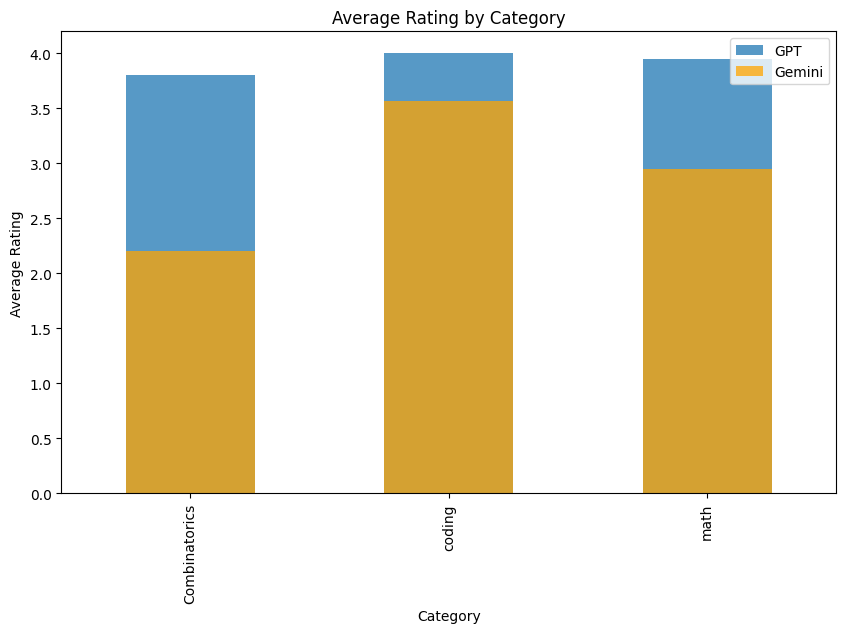

In [84]:
import matplotlib.pyplot as plt

# Calculate the average score based on category and model
average_ratings1 = df.groupby(['Category'])['GPT_Rating'].mean()
average_ratings2 = df.groupby(['Category'])['Gemini_Rating'].mean()

# Create a new figure and set the size
plt.figure(figsize=(10, 6))

# Plot the average ratings
average_ratings1.plot(kind='bar', alpha=0.75, label='GPT')
average_ratings2.plot(kind='bar', alpha=0.75, color='orange', label='Gemini')

# Add labels and title
plt.ylabel('Average Rating')
plt.title('Average Rating by Category')

# Add a legend
plt.legend()

# Show the plot
plt.show()